## First draft of Contrast algorithm

## To do
- ✔ Compute standard_distances for each cluster
- When updating st_dists of cluster, project along both infinite-stdev and
  0-stdev dims
- Update sensitivity -> how?
- Inverse law when seeing duplicates
- Implement context
- Compare stdevs and distances
- Clustering validity checking methods
- Recollection: random updates vs complete updates?

## Not to do
- Implement a tree-like structure (not relevant if we update only one
  outlier point we saw early)

## Imports

In [38]:
# import time
# import csv
import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from scipy.stats import chi2
from scipy.stats import special_ortho_group
from scipy.spatial.distance import mahalanobis
from sklearn import metrics
from utils import plot_confusion_matrix
import collections, functools, itertools

np.random.seed(1)

## Global variables

In [27]:
NB_FEATURES = 5
NB_GROUPS = 10
N = 200
DOMAIN_LENGTH = 200
DEV_MAX = 20

COLORS = ['r', 'g', 'b', 'y', 'c', 'm']

# stocks metadata as (DATASET_NAME, DATASET_EXTENSION, DATASET_PATH,
#     \ DATASET_CLUSTER_COLUMN_INDEX, DATASET_DATA_COLUMNS_INDICES)
METADATA = {
    'Cards': ('Cards', '.csv', 'data/', 1, (2, None)),
    'Cards_truncated': ('Cards', '.csv', 'data/', 1, (2, 7))
}

SHOULD_LOAD_DATASET = 1  # 0 to generate, 1 to load
if SHOULD_LOAD_DATASET:
    NAME = 'Cards'
    DATASET_NAME, DATASET_EXTENSION, DATASET_PATH, \
        DATASET_CLUSTER_COLUMN_INDEX, \
        DATASET_DATA_COLUMNS_INDICES = METADATA[NAME]
    DATASET_PATH_FULL = DATASET_PATH + DATASET_NAME + DATASET_EXTENSION
else:
    DATASET_PATH = 'data/'
    DATASET_NAME = 'dummy'

## Helper functions

In [28]:
def generate_cluster(n_cluster, nb_features=NB_FEATURES, d=DOMAIN_LENGTH,
                     dev_max=DEV_MAX, method='byhand'):
    """
    The 'method' argument can be one of the following:
    - 'byhand'
    - 'multinormal'
    """
    mean = np.random.random(nb_features) * d
    if method == 'multinormal':
        # /!\ does not work: data does not seem random at all, covariance is
        # always positive...!
        raise DeprecationWarning("beware, 'multinormal' method does not seem"
                                 "to work")
        cov = np.tril(np.random.random((nb_features, n_cluster)) *
                      np.random.random() * dev_max)
        cov = cov @ cov.transpose()  # a covariance matrix
        return(np.random.multivariate_normal(mean, cov, n_cluster))
    else:
        if method != 'byhand':
            print("generate_cluster: method unknown, using 'byhand'")
        st_devs = dev_max * np.random.random(nb_features)
        # holds the st_devs of each feature
        cluster_points = np.zeros((n_cluster, nb_features))
        for i in range(n_cluster):
            for j in range(nb_features):
                cluster_points[i][j] = np.random.normal(loc=mean[j],
                                                        scale=st_devs[j])
        cluster_points = cluster_points @ special_ortho_group.rvs(nb_features)
        return(cluster_points)


def generate_dataset(nb_groups=NB_GROUPS, n=N, nb_features=NB_FEATURES,
                     d=DOMAIN_LENGTH, dev_max=DEV_MAX):
    group_sizes = np.random.random(nb_groups)
    group_sizes *= n / np.sum(group_sizes)
    group_sizes = np.trim_zeros(np.round(group_sizes)).astype(int)
    data = [generate_cluster(n_cluster) for n_cluster in group_sizes]
    data = np.vstack(data)
    clusters_true = np.concatenate([n_cluster * [i] for i, n_cluster in
                                    enumerate(group_sizes)])
    np.save(DATASET_PATH + DATASET_NAME + '_data.npy', data)
    np.save(DATASET_PATH + DATASET_NAME + '_clusters_true.npy', clusters_true)


# def old_generate_dataset(nb_groups=NB_GROUPS, n=N, nb_features=NB_FEATURES,
#                          d=DOMAIN_LENGTH, dev_max=DEV_MAX):
#     clusters_true = np.zeros(n)
#     means = np.zeros((nb_groups,
#                       nb_features))  # holds the mean of each group
#     st_devs = np.zeros((nb_groups, nb_features))
#     # holds the st_devs of each group
#     for i in range(nb_groups):
#         for j in range(nb_features):
#             means[i][j] = np.random.randint(-d, d)
#             st_devs[i][j] = dev_max*np.random.random()
#     data = np.zeros((n, nb_features))
#     for i in range(n):
#         gi = np.random.randint(0, nb_groups)
#         clusters_true[i] = gi
#         for j in range(nb_features):
#             data[i][j] = np.random.normal(loc=means[gi][j],
#                                           scale=st_devs[gi][j])
#     np.save(DUMMY_DATA_PATH, data)
#     np.save(DUMMY_CLUSTERS_TRUE_PATH, clusters_true)


def distance(p, q, ord=2):
    return(np.linalg.norm(p-q, ord))


def get_outlier_ratio(p, cluster_points, method='maha', alpha=0.95):
    """
    The 'method' argument can be either of the following:
    - 'maha': Mahalanobis distance, generalization of the distance to
              the mean in terms of standard deviations for multivariate data
    - 'cook':
    - 'mmcd':
    """
    threshold = chi2.isf(1-alpha, p.shape[1])
    if method == 'cook':
        raise NotImplementedError("'cook' method not yet implemented")
    elif method == 'mmcd':
        raise NotImplementedError("'mmcd' method not yet implemented")
    else:
        if method != 'maha':
            print("Unknown method, using Mahalanobis distance")
        sigma = np.cov(cluster_points)
        mu = np.mean(cluster_points, axis=0)
        d = mahalanobis(p, mu, np.linalg.inv(sigma))
        ratio = d / threshold
        return ratio

## Generate or load dataset

In [29]:
if SHOULD_LOAD_DATASET:
    start, end = DATASET_DATA_COLUMNS_INDICES
    df1 = pd.read_csv(DATASET_PATH_FULL)
    df1_np = df1.to_numpy(copy=True)
    data = df1_np[:, start:end].astype('float')
    clusters_true = df1_np[:, DATASET_CLUSTER_COLUMN_INDEX]
else:
    generate_dataset()
    data = np.load(DATASET_PATH + DATASET_NAME + '_data.npy')
    clusters_true = np.load(DATASET_PATH + DATASET_NAME +
                            '_clusters_true.npy').astype(int)

assert data is not None, 'data is None'
assert clusters_true is not None, 'clusters_true is None'

# print(data)
# print(clusters_true)

## Preview dataset

/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


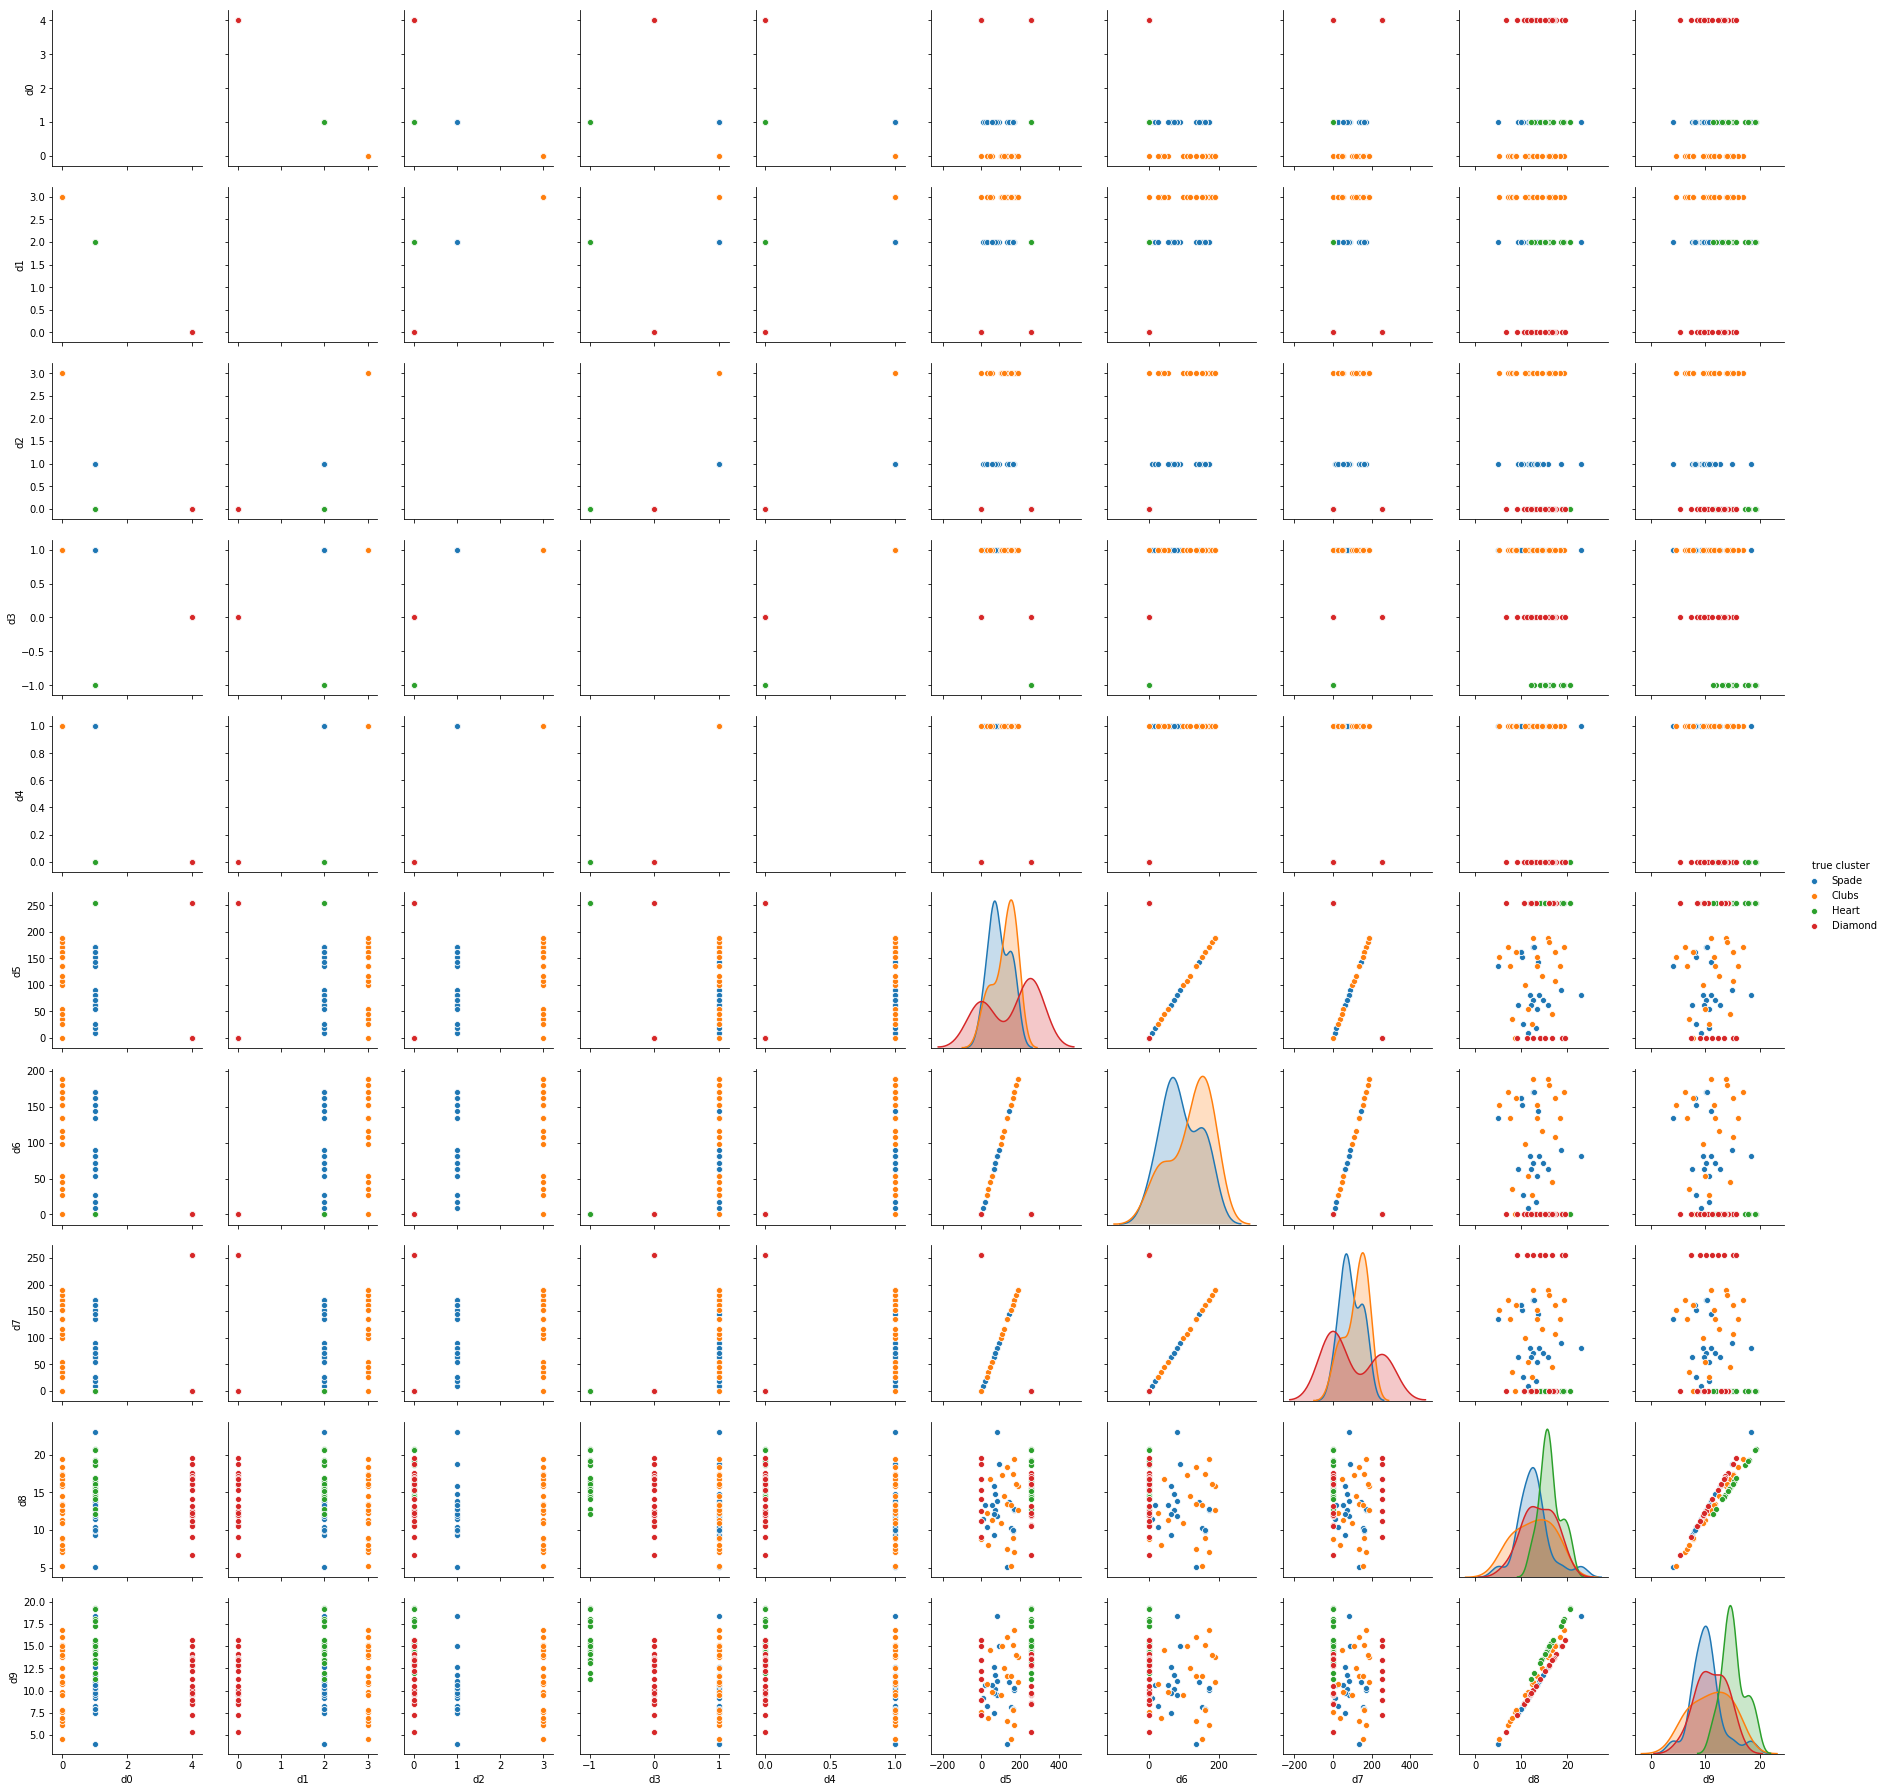

In [30]:
columns = ["d" + str(i) for i in range(data.shape[1])] + ['true cluster']
df = pd.DataFrame(np.hstack((data, np.reshape([clusters_true],
                                              (data.shape[0], 1)))),
                  columns=columns)
true_data_plot = sns.pairplot(df, kind="scatter", hue='true cluster',
                              vars=columns[:-1])
true_data_plot.savefig(DATASET_PATH + DATASET_NAME + '_true.png')

## The agent

In [31]:
class ContrastAgent(object):
    def __init__(self, sensitivenesses=[1, 10, 0.1], shuffleToggle=False,
                 verbose=False):

        # --- user-defined parameters ---
        self.sensitiveness_find_cluster = sensitivenesses[0]
        # if a point is alone with a radius of
        # sensitiveness_find_cluster * stdist, create a new cluster
        self.sensitiveness_inf_dims = sensitivenesses[1]
        # sensitiveness to determine if a dimension is too variable to be
        # relevant for the cluster
        self.sensitiveness_zero_dims = sensitivenesses[2]
        # sensitiveness to determine if a dimension is too concentrated to be
        # relevant for the cluster
        self.shuffleToggle = shuffleToggle
        self.verbose = verbose

        # --- other parameters ---
        self.clusters = np.array([])
        # clusters[i] == j means that point i belongs to cluster j
        self.cluster_sizes = []
        self.data = np.array([[]])
        self.first_time = True  # is True if nb
        self.nb_clusters = 0
        self.nb_seen = 0
        self.permutation = None
        self.stdist = 0
        self.stdists_per_cluster = []

    def clusterize_online(self):
        assert len(self.data), "empty data"
        if self.nb_clusters == 0:
            self.new_cluster(0)
            self.one_more_seen()
        for i, p in enumerate(self.data[self.nb_seen:], start=self.nb_seen):
            allZeros = self.find_cluster(i, p, until=i)
            if not allZeros:
                self.one_more_seen()

    def feed_data(self, d):
        """Adds data to the agent's memory"""
        data = np.copy(d)
        if self.shuffleToggle:
            data = self.shuffle(data)
        if self.nb_clusters == 0:
            self.data = np.copy(data)
            self.clusters = np.zeros(len(data), dtype=int)
            self.clusters.fill(-1)
        else:
            new_data = np.vstack((self.data, np.copy(data)))
            self.data = new_data
            new_clusters = np.zeros(len(data), dtype=int)
            new_clusters.fill(-1)
            new_clusters_all = np.hstack((self.clusters, new_clusters))
            self.clusters = new_clusters_all

    def find_cluster(self, i, p, until=None, recollection=False):
        distances = np.array([distance(p, q) for q in self.data[:until]])
        allZeros = np.all(distances == 0)
        dist_min = np.min(np.trim_zeros(distances)) if not allZeros else 0
        closest = np.argmin(distances)
        if dist_min > self.sensitiveness_find_cluster * self.stdist and \
                0 not in distances:
            if self.verbose:
                print("{} -> new cluster".format(i))
            if self.clusters[i] == -1 or \
                    not self.cluster_sizes[self.clusters[i]] == 1:
                # if p not already seen or is not already alone
                self.new_cluster(i)
        else:
            if self.verbose:
                print("{} -> cluster of {}".format(i, closest))
            self.clusters[i] = self.clusters[closest]
            if not allZeros:
                self.update_stdists_per_cluster(self.clusters[i], p)
            self.cluster_sizes[self.clusters[i]] += 1
        if not recollection and not allZeros:
            self.update_stdist(self.nb_seen, dist_min)
        return allZeros

    def get_cluster_dimensions(self, i):
        """ return (relevant_dims, inf_dims, zero_dims) """
        stdist_i = self.stdists_per_cluster[i]
        cluster_points = self.get_cluster_points(i)
        relevant_dims, inf_dims, zero_dims = [], [], []
        for j in range(cluster_points.shape[1]):
            stdev = np.std(cluster_points[:, j])
            if stdev > self.sensitiveness_inf_dims * stdist_i:
                inf_dims.append(j)
            elif stdev < self.sensitiveness_zero_dims * stdist_i:
                zero_dims.append(j)
            else:
                relevant_dims.append(j)
        return relevant_dims, inf_dims, zero_dims

    def get_cluster_points(self, i):
        return data[np.argwhere(self.clusters == i)]

    def new_cluster(self, p_index):
        self.clusters[p_index] = self.nb_clusters
        self.nb_clusters += 1
        self.cluster_sizes.append(1)
        self.stdists_per_cluster.append(0)

    def one_more_seen(self):
        self.nb_seen += 1

    def print_clusters(self):
        columns = ["d" + str(i) for i in range(self.data.shape[1])] \
                  + ['affected cluster']
        df_1 = pd.DataFrame(np.hstack((self.data,
                                       np.reshape([self.clusters],
                                                  (self.data.shape[0], 1)))),
                            columns=columns)
        agent_plot = sns.pairplot(df_1, kind="scatter", hue="affected cluster",
                                  vars=columns[:-1])
        agent_plot.savefig(DATASET_PATH + DATASET_NAME + '_agent.png')

    def print_scores(self):
        pass

    def shuffle(self, data_to_shuffle):
        new_permutation = np.random.permutation(len(data_to_shuffle))
        if self.permutation is None:
            self.permutation = new_permutation
        else:
            new_permutation2 = new_permutation + len(self.permutation)
            self.permutation = np.concatenate([self.permutation,
                                               new_permutation2])
        return(data_to_shuffle[new_permutation])

    def update_clusters(self, until_update=None, until_dist=None,
                        recollection=True):
        for i, p in enumerate(self.data[:until_update]):
            self.find_cluster(i, p, until=until_dist,
                              recollection=recollection)

    def update_stdist(self, nb_seen, distance):
        old_dist = self.stdist
        self.stdist = (max(1, nb_seen-1) * self.stdist + distance) / (nb_seen)
        if self.verbose:
            print('distance = {}, self.stdist = {} -> {}'.format(
                distance, old_dist, self.stdist))

    def update_stdists_per_cluster(self, i, p):
        old_dist = self.stdists_per_cluster[i]
        relevant_dims, inf_dims, zero_dims = self.get_cluster_dimensions(i)
        if len(relevant_dims):
            cluster_points_rd = self.get_cluster_points(i)[:, relevant_dims]
            p_rd = p[relevant_dims]
        elif len(inf_dims):
            cluster_points_rd = self.get_cluster_points(i)[:, inf_dims]
            p_rd = p[inf_dims]
        else:
            cluster_points_rd = self.get_cluster_points(i)[:, zero_dims]
            p_rd = p[zero_dims]
        array_dists = np.array([distance(p_rd, q) for q in cluster_points_rd])
#         print(relevant_dims, inf_dims, zero_dims)
#         print(array_dists)
        dist_p = np.min(array_dists)
        csize = cluster_points_rd.shape[0]
        self.stdists_per_cluster[i] = (old_dist * csize + dist_p) / (csize + 1)

Final stdist: 16.202230176259068
All points in a cluster? True


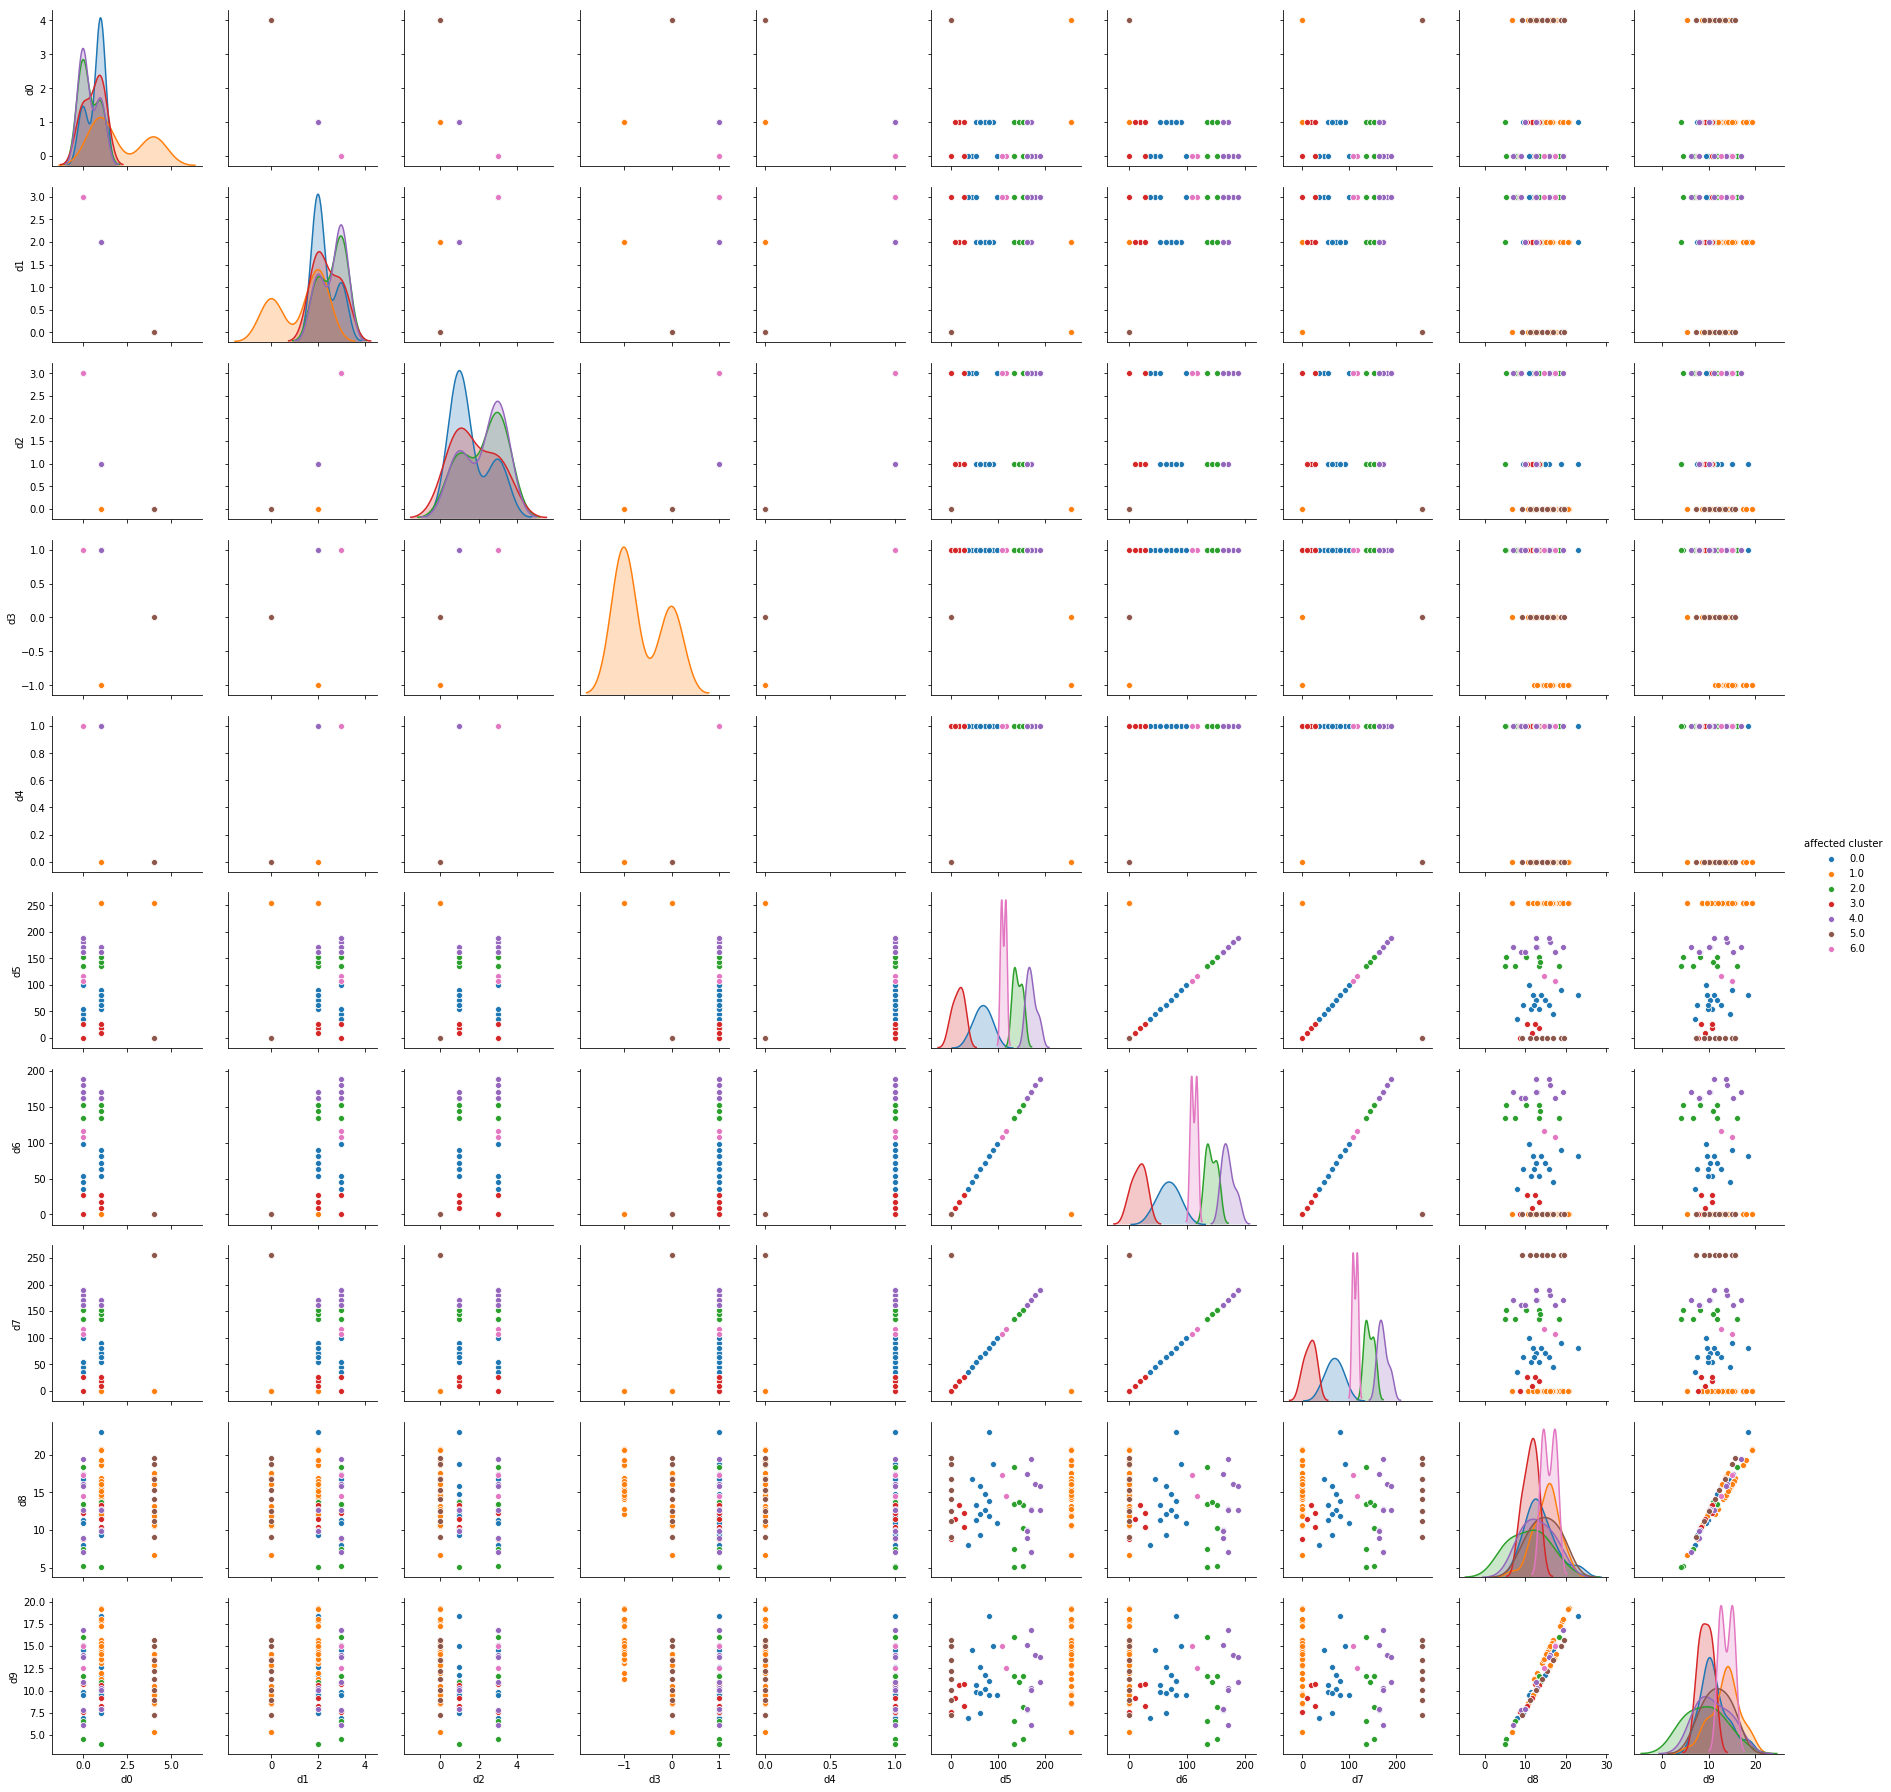

In [32]:
ca = ContrastAgent(sensitivenesses=[1.25, 10, 0.1], shuffleToggle=True,
                   verbose=False)
ca.feed_data(data)
ca.clusterize_online()
print("Final stdist: {}".format(ca.stdist))
print("All points in a cluster? {}".format(-1 not in ca.clusters))
ca.print_clusters()

## Performance metrics

Metrics involving ground truth
Adjusted Rand Index: 0.3714327396783714
Adjusted Mutual Information score: 0.44663506491120913
Homogeneity: 0.5905120975011762
Completeness: 0.49008231483219544
V-measure score: 0.5356302649296127
Fowlkes-Mallows score: 0.5176708169804182

Metrics not involving ground truth
Silhouette score (original): 0.1312928628658776
Silhouette score (agent): 0.719214983319256
Calinski-Harabaz score (original): 18.441347854680224
Calinski-Harabaz score (agent): 995.8345817566286
Davies-Bouldin score (original): 2.5569270994140307
Davies-Bouldin score (agent): 0.4047981038067161

Normalized confusion matrix
[[0.5  0.   0.15 0.15 0.2  0.   0.  ]
 [0.2  0.   0.25 0.1  0.35 0.   0.1 ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.6  0.   0.   0.   0.4  0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/run/media/ashikaga/DATA/cyril/school/polytechnique/3a/stage/telecom/contrast-learning/utils.py:28: RuntimeWarning: invalid value encountered in true_divide
  cm = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


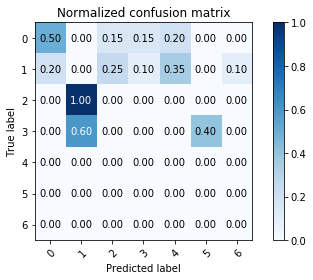

In [40]:
if clusters_true is not None:
    # clusters_true2 will contain ids instead of labels
    ids = collections.defaultdict(functools.partial(next, itertools.count()))
    clusters_true2 = np.array([ids[label] for label in clusters_true])
    if ca.shuffleToggle:
        clusters_true2 = clusters_true2[ca.permutation]
    print("Metrics involving ground truth")
    print("Adjusted Rand Index: {}".format(
        metrics.adjusted_rand_score(clusters_true2, ca.clusters)))
    print("Adjusted Mutual Information score: {}".format(
        metrics.adjusted_mutual_info_score(clusters_true2, ca.clusters)))
    print("Homogeneity: {}".format(
        metrics.homogeneity_score(clusters_true2, ca.clusters)))
    print("Completeness: {}".format(
        metrics.completeness_score(clusters_true2, ca.clusters)))
    print("V-measure score: {}".format(
        metrics.v_measure_score(clusters_true2, ca.clusters)))
    print("Fowlkes-Mallows score: {}".format(
        metrics.fowlkes_mallows_score(clusters_true2, ca.clusters)))
    print()
    
print("Metrics not involving ground truth")
if clusters_true is not None:
    print("Silhouette score (original): {}".format(
        metrics.silhouette_score(data, clusters_true)))
print("Silhouette score (agent): {}".format(
    metrics.silhouette_score(ca.data, ca.clusters)))
if clusters_true is not None:
    print("Calinski-Harabaz score (original): {}".format(
        metrics.calinski_harabaz_score(data, clusters_true)))
print("Calinski-Harabaz score (agent): {}".format(
    metrics.calinski_harabaz_score(ca.data, ca.clusters)))
if clusters_true is not None:
    print("Davies-Bouldin score (original): {}".format(
        metrics.davies_bouldin_score(data, clusters_true)))
print("Davies-Bouldin score (agent): {}".format(
    metrics.davies_bouldin_score(ca.data, ca.clusters)))

if clusters_true is not None:
    print()
    class_names = np.array([str(i) for i in range(1+np.max(
                                np.concatenate([clusters_true2, ca.clusters])))])
    plot_confusion_matrix(clusters_true2, ca.clusters, classes=class_names,
                      normalize=True, title='Normalized confusion matrix',
                      path=DATASET_PATH + DATASET_NAME)